In [1]:
"""
Gold Price Prediction - Hyperparameter Tuning
==============================================
Optimize models using GridSearchCV, RandomizedSearchCV, and manual LSTM tuning
"""

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import json

# ML Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# MLflow
import mlflow
import mlflow.sklearn

print("="*70)
print("HYPERPARAMETER TUNING")
print("="*70)
print(f"TensorFlow: {tf.__version__}")
print()

HYPERPARAMETER TUNING
TensorFlow: 2.20.0



In [2]:
# ============================================================================
# DATA PREPARATION
# ============================================================================
print("Fetching data...")
data = yf.download("GC=F", period="5y", progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(f"✓ Downloaded {len(data)} days")

# Feature Engineering
featured_data = data.copy()
featured_data['Returns'] = featured_data['Close'].pct_change()
featured_data['Log_Returns'] = np.log(featured_data['Close'] / featured_data['Close'].shift(1))

for window in [5, 10, 20, 50]:
    featured_data[f'MA_{window}'] = featured_data['Close'].rolling(window=window).mean()
    featured_data[f'MA_Ratio_{window}'] = featured_data['Close'] / featured_data[f'MA_{window}']

for window in [5, 10, 20]:
    featured_data[f'Volatility_{window}'] = featured_data['Returns'].rolling(window=window).std()

for lag in [1, 5, 10, 20]:
    featured_data[f'Momentum_{lag}'] = featured_data['Close'] - featured_data['Close'].shift(lag)
    featured_data[f'ROC_{lag}'] = featured_data['Close'].pct_change(lag)

featured_data['HL_Range'] = featured_data['High'] - featured_data['Low']
featured_data['HL_Pct'] = featured_data['HL_Range'] / featured_data['Close']
featured_data['Volume_MA_5'] = featured_data['Volume'].rolling(window=5).mean()
featured_data['Volume_Ratio'] = featured_data['Volume'] / featured_data['Volume_MA_5']

for lag in [1, 2, 3, 5]:
    featured_data[f'Close_Lag_{lag}'] = featured_data['Close'].shift(lag)

featured_data['Target'] = featured_data['Close'].shift(-1)
featured_data = featured_data.dropna()

# Prepare sklearn data
exclude_cols = ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
feature_cols = [col for col in featured_data.columns if col not in exclude_cols]

X = featured_data[feature_cols]
y = featured_data['Target']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print(f"✓ Train: {len(X_train)}, Test: {len(X_test)}")
print(f"✓ Features: {len(feature_cols)}")

Fetching data...
✓ Downloaded 1258 days
✓ Train: 966, Test: 242
✓ Features: 29


In [3]:
# ============================================================================
# 1. RIDGE REGRESSION - GridSearchCV
# ============================================================================
print("="*70)
print("TUNING RIDGE REGRESSION")
print("="*70)

ridge_params = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)

ridge_grid.fit(X_train_scaled, y_train)

print(f"\n🏆 Best Ridge params: {ridge_grid.best_params_}")
print(f"   Best CV score: {-ridge_grid.best_score_*100:.2f}% MAPE")

# Test performance
ridge_best = ridge_grid.best_estimator_
ridge_pred = ridge_best.predict(X_test_scaled)
ridge_mape = np.mean(np.abs((y_test.values - ridge_pred) / y_test.values)) * 100
print(f"   Test MAPE: {ridge_mape:.2f}%")

TUNING RIDGE REGRESSION
Fitting 5 folds for each of 8 candidates, totalling 40 fits

🏆 Best Ridge params: {'alpha': 0.1}
   Best CV score: 0.77% MAPE
   Test MAPE: 1.01%


In [4]:
# ============================================================================
# 2. RANDOM FOREST - RandomizedSearchCV
# ============================================================================
print("="*70)
print("TUNING RANDOM FOREST")
print("="*70)

rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random.fit(X_train_scaled, y_train)

print(f"\n🏆 Best RF params: {rf_random.best_params_}")
print(f"   Best CV score: {-rf_random.best_score_*100:.2f}% MAPE")

rf_best = rf_random.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)
rf_mape = np.mean(np.abs((y_test.values - rf_pred) / y_test.values)) * 100
print(f"   Test MAPE: {rf_mape:.2f}%")

TUNING RANDOM FOREST
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🏆 Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}
   Best CV score: 3.65% MAPE
   Test MAPE: 20.96%


In [5]:
# ============================================================================
# 3. XGBOOST - RandomizedSearchCV
# ============================================================================
print("="*70)
print("TUNING XGBOOST")
print("="*70)

xgb_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    xgb_params,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train_scaled, y_train)

print(f"\n🏆 Best XGBoost params: {xgb_random.best_params_}")
print(f"   Best CV score: {-xgb_random.best_score_*100:.2f}% MAPE")

xgb_best = xgb_random.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)
xgb_mape = np.mean(np.abs((y_test.values - xgb_pred) / y_test.values)) * 100
print(f"   Test MAPE: {xgb_mape:.2f}%")

TUNING XGBOOST
Fitting 5 folds for each of 30 candidates, totalling 150 fits

🏆 Best XGBoost params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
   Best CV score: 3.68% MAPE
   Test MAPE: 21.00%


In [6]:
# ============================================================================
# 4. GRADIENT BOOSTING - RandomizedSearchCV
# ============================================================================
print("="*70)
print("TUNING GRADIENT BOOSTING")
print("="*70)

gb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_random.fit(X_train_scaled, y_train)

print(f"\n🏆 Best GB params: {gb_random.best_params_}")
print(f"   Best CV score: {-gb_random.best_score_*100:.2f}% MAPE")

gb_best = gb_random.best_estimator_
gb_pred = gb_best.predict(X_test_scaled)
gb_mape = np.mean(np.abs((y_test.values - gb_pred) / y_test.values)) * 100
print(f"   Test MAPE: {gb_mape:.2f}%")

TUNING GRADIENT BOOSTING
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🏆 Best GB params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
   Best CV score: 3.62% MAPE
   Test MAPE: 21.19%


In [7]:
# ============================================================================
# 5. LSTM - Manual Grid Search
# ============================================================================
print("="*70)
print("TUNING LSTM")
print("="*70)

# Prepare LSTM data
close_prices = data['Close'].values.reshape(-1, 1)
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = lstm_scaler.fit_transform(close_prices)

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# LSTM hyperparameter grid
lstm_configs = [
    {'lookback': 20, 'units': 50, 'dropout': 0.2, 'epochs': 60},
    {'lookback': 30, 'units': 50, 'dropout': 0.2, 'epochs': 60},
    {'lookback': 20, 'units': 100, 'dropout': 0.2, 'epochs': 60},
    {'lookback': 20, 'units': 50, 'dropout': 0.3, 'epochs': 60},
    {'lookback': 30, 'units': 100, 'dropout': 0.2, 'epochs': 80},
    {'lookback': 60, 'units': 50, 'dropout': 0.2, 'epochs': 60},
]

lstm_results = []

for i, config in enumerate(lstm_configs):
    print(f"\nConfig {i+1}/{len(lstm_configs)}: {config}")
    
    # Create sequences with this lookback
    X_lstm, y_lstm = create_sequences(scaled_prices, config['lookback'])
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
    
    split = int(len(X_lstm) * 0.8)
    X_train_l, X_test_l = X_lstm[:split], X_lstm[split:]
    y_train_l, y_test_l = y_lstm[:split], y_lstm[split:]
    
    # Build model
    model = Sequential([
        LSTM(units=config['units'], return_sequences=True, input_shape=(config['lookback'], 1)),
        Dropout(config['dropout']),
        LSTM(units=config['units'], return_sequences=False),
        Dropout(config['dropout']),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_l, y_train_l, epochs=config['epochs'], batch_size=32,
              validation_split=0.1, callbacks=[early_stop], verbose=0)
    
    # Evaluate
    pred_scaled = model.predict(X_test_l, verbose=0)
    pred = lstm_scaler.inverse_transform(pred_scaled).flatten()
    actual = lstm_scaler.inverse_transform(y_test_l.reshape(-1, 1)).flatten()
    
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    
    # Direction accuracy
    actual_dir = (actual[1:] > actual[:-1]).astype(int)
    pred_dir = (pred[1:] > pred[:-1]).astype(int)
    dir_acc = (actual_dir == pred_dir).mean() * 100
    
    lstm_results.append({
        'config': config,
        'mape': mape,
        'direction_accuracy': dir_acc
    })
    
    print(f"   MAPE: {mape:.2f}%, Direction: {dir_acc:.1f}%")
    
    # Clear session to free memory
    tf.keras.backend.clear_session()

TUNING LSTM

Config 1/6: {'lookback': 20, 'units': 50, 'dropout': 0.2, 'epochs': 60}
   MAPE: 1.51%, Direction: 51.8%


Config 2/6: {'lookback': 30, 'units': 50, 'dropout': 0.2, 'epochs': 60}
   MAPE: 1.41%, Direction: 51.0%

Config 3/6: {'lookback': 20, 'units': 100, 'dropout': 0.2, 'epochs': 60}
   MAPE: 1.30%, Direction: 52.2%

Config 4/6: {'lookback': 20, 'units': 50, 'dropout': 0.3, 'epochs': 60}
   MAPE: 1.43%, Direction: 51.0%

Config 5/6: {'lookback': 30, 'units': 100, 'dropout': 0.2, 'epochs': 80}
   MAPE: 1.13%, Direction: 49.0%

Config 6/6: {'lookback': 60, 'units': 50, 'dropout': 0.2, 'epochs': 60}
   MAPE: 1.50%, Direction: 52.3%


In [8]:
# ============================================================================
# LSTM TUNING RESULTS
# ============================================================================
print("="*70)
print("LSTM TUNING RESULTS")
print("="*70)

lstm_df = pd.DataFrame([
    {**r['config'], 'mape': r['mape'], 'direction_accuracy': r['direction_accuracy']}
    for r in lstm_results
])
lstm_df = lstm_df.sort_values('mape')
print(lstm_df.to_string(index=False))

best_lstm = lstm_results[lstm_df.index[0]]
print(f"\n🏆 Best LSTM config: {best_lstm['config']}")
print(f"   MAPE: {best_lstm['mape']:.2f}%")
print(f"   Direction Accuracy: {best_lstm['direction_accuracy']:.1f}%")

LSTM TUNING RESULTS
 lookback  units  dropout  epochs     mape  direction_accuracy
       30    100      0.2      80 1.130678           48.979592
       20    100      0.2      60 1.300801           52.226721
       30     50      0.2      60 1.405208           51.020408
       20     50      0.3      60 1.428347           51.012146
       60     50      0.2      60 1.502701           52.301255
       20     50      0.2      60 1.505440           51.821862

🏆 Best LSTM config: {'lookback': 30, 'units': 100, 'dropout': 0.2, 'epochs': 80}
   MAPE: 1.13%
   Direction Accuracy: 49.0%


In [9]:
# ============================================================================
# FINAL COMPARISON - TUNED MODELS
# ============================================================================
print("="*70)
print("TUNED MODELS COMPARISON")
print("="*70)

tuned_results = {
    'Ridge': {'mape': ridge_mape, 'best_params': ridge_grid.best_params_},
    'Random Forest': {'mape': rf_mape, 'best_params': rf_random.best_params_},
    'XGBoost': {'mape': xgb_mape, 'best_params': xgb_random.best_params_},
    'Gradient Boosting': {'mape': gb_mape, 'best_params': gb_random.best_params_},
    'LSTM': {'mape': best_lstm['mape'], 'best_params': best_lstm['config'], 'direction_accuracy': best_lstm['direction_accuracy']}
}

# Display results
for name, result in sorted(tuned_results.items(), key=lambda x: x[1]['mape']):
    print(f"\n{name}:")
    print(f"   MAPE: {result['mape']:.2f}%")
    print(f"   Best params: {result['best_params']}")
    if 'direction_accuracy' in result:
        print(f"   Direction: {result['direction_accuracy']:.1f}%")

TUNED MODELS COMPARISON

Ridge:
   MAPE: 1.01%
   Best params: {'alpha': 0.1}

LSTM:
   MAPE: 1.13%
   Best params: {'lookback': 30, 'units': 100, 'dropout': 0.2, 'epochs': 80}
   Direction: 49.0%

Random Forest:
   MAPE: 20.96%
   Best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}

XGBoost:
   MAPE: 21.00%
   Best params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

Gradient Boosting:
   MAPE: 21.19%
   Best params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}


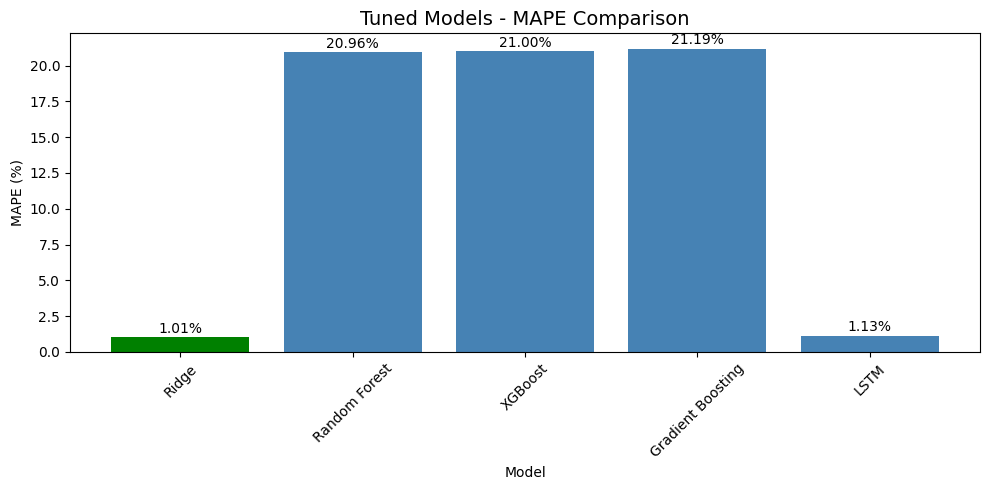

In [10]:
# ============================================================================
# VISUALIZATION
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 5))

models = list(tuned_results.keys())
mapes = [tuned_results[m]['mape'] for m in models]

colors = ['green' if m == min(mapes) else 'steelblue' for m in mapes]
bars = ax.bar(models, mapes, color=colors)

ax.set_title('Tuned Models - MAPE Comparison', fontsize=14)
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Model')

for bar, mape in zip(bars, mapes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{mape:.2f}%', ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# ============================================================================
# SAVE BEST PARAMETERS
# ============================================================================
print("="*70)
print("SAVING BEST PARAMETERS")
print("="*70)

best_params = {
    'ridge': ridge_grid.best_params_,
    'random_forest': rf_random.best_params_,
    'xgboost': xgb_random.best_params_,
    'gradient_boosting': gb_random.best_params_,
    'lstm': best_lstm['config'],
    'tuning_date': datetime.now().isoformat()
}

with open('../models/best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("✓ Saved to ../models/best_hyperparameters.json")
print()
print(json.dumps(best_params, indent=2))

print()
print("="*70)
print("🎉 HYPERPARAMETER TUNING COMPLETE!")
print("="*70)

SAVING BEST PARAMETERS
✓ Saved to ../models/best_hyperparameters.json

{
  "ridge": {
    "alpha": 0.1
  },
  "random_forest": {
    "n_estimators": 200,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "max_depth": 20
  },
  "xgboost": {
    "subsample": 0.7,
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "colsample_bytree": 0.7
  },
  "gradient_boosting": {
    "subsample": 0.7,
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.05
  },
  "lstm": {
    "lookback": 30,
    "units": 100,
    "dropout": 0.2,
    "epochs": 80
  },
  "tuning_date": "2026-01-07T14:43:05.567015"
}

🎉 HYPERPARAMETER TUNING COMPLETE!
